In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| default_exp functions

## Overview
Each function outputs the result of applying the function logic and may be a scalar or array, depending on the input. The inputs are supplied as links to another function, from where the values are read. Unless the function is a simple case, such as a 'Constant'. 

Parameters are supplied as arguments to the constructor of the class.

All functions include the methods defined by the BaseFunction class.

In [ ]:
#| export
#import numpy as np
from enum import IntEnum, auto
import random
import uuid
from abc import ABC, abstractmethod
from pct.putils import sigmoid
from pct.putils import smooth
from pct.putils import dot
from pct.putils import UniqueNamer
from pct.putils import FunctionsList

In [ ]:
#| export
class HPCTFUNCTION(IntEnum):
    "Types of control functions in a node."
    PERCEPTION = auto()
    REFERENCE = auto()
    COMPARATOR = auto()
    OUTPUT = auto()
    ACTION = auto()
    
# class ControlUnitFunctions(enum.IntEnum):
#    PERCEPTION = 0
#    REFERENCE = 1
#    COMPARATOR = 2
#    OUTPUT = 3

# class CUF(enum.IntEnum):
#    PERCEPTION = 0
#    REFERENCE = 1
#    COMPARATOR = 2
#    OUTPUT = 3
#    ACTION = 4 
    

In [ ]:
#| export
class BaseFunction(ABC):
    "Base class of a PCT function. This class is not used directly by developers, but defines the functionality common to all."
    def __init__(self, name=None, value=None, links=None, new_name=True, namespace=None):
        if namespace ==None:
            namespace = uuid.uuid1()
        self.namespace=namespace

        
        self.value = value
        self.links = []
        self.handle_links(links)
        self.checklinks=True
                
        #print(f'size {len(UniqueNamer.getInstance().names)} {name} {name in UniqueNamer.getInstance().names}', end=" ")
        if new_name:
            self.name = UniqueNamer.getInstance().get_name(namespace, name)
        else:
            self.name = name                
        #print(self.name)
        FunctionsList.getInstance().add_function(namespace, self)
        self.decimal_places = 3
        
    def change_namespace(self, namespace):
        self.namespace=namespace
        UniqueNamer.getInstance().get_name(namespace, self.name)
        FunctionsList.getInstance().add_function(namespace, self)
        
        
    @abstractmethod
    def __call__(self, verbose=False):
        if verbose :
            print(self.output_string(), end= " ")
            
        return self.value

    def get_suffix(self):
        return ''
    
    def reset(self):
        self.value = 0        
        self.links = []
        self.checklinks=True
        
    def reset_links(self, prefix, level):
        self.links = []
        for column in range(len(self.weights)):
            name = f'{prefix}L{level}C{column}'
            self.links.append(name)

    def validate(self, num):
        if len(self.links) != num:
            raise Exception(f'Number of links, {len(self.links)}, for {self.name} is not equal to {num}')
                
            
    def run(self, steps=None, verbose=False):
        for i in range(steps):
            out = self(verbose)
        return out

    def reset_checklinks(self, val=True):
        self.checklinks=val
    
    def handle_links(self, links):
        if links!=None:
            if isinstance(links, dict):
                if len(links)>0:
                    for key in links.keys():
                        self.links.append(FunctionsList.getInstance().get_function(self.namespace, links[key]))
                return

            if isinstance(links, list):
                for link in links:
                    if isinstance(link, str):
                        self.links.append(FunctionsList.getInstance().get_function(self.namespace, link))
                    else:
                        self.links.append(link)
                return
        
            if isinstance(links, str):
                self.links.append(FunctionsList.getInstance().get_function(self.namespace, links))
                return
            
            self.links.append(links)
                
    def draw(self, with_labels=True,  font_size=12, font_weight='bold', node_color=None, 
             color_mapping={'s':'aqua','c':'limegreen','p':'red', 'x':'silver'},
             node_size=500, arrowsize=25, align='horizontal', file=None):
        graph = self.graph(layer=0, layer_edges=True)
        if node_color==None:
            node_color = self.get_colors(graph, color_mapping)
        pos = nx.multipartite_layout(graph, subset_key="layer", align=align)
        nx.draw(graph,  pos=pos, with_labels=with_labels, font_size=font_size, font_weight=font_weight,
                node_color=node_color,  node_size=node_size, arrowsize=arrowsize)

    def get_capital(self, ftype):
        rtn = None
        if ftype == HPCTFUNCTION.PERCEPTION:
            rtn ='P'            
        if ftype == HPCTFUNCTION.REFERENCE:
            rtn ='R'
        if ftype == HPCTFUNCTION.COMPARATOR:
            rtn ='C'
        if ftype == HPCTFUNCTION.OUTPUT:
            rtn ='O'
        
        return rtn 
    
    def get_colors(self, graph, color_mapping):
        colors=[]
        for node in graph:
            color = 'darkorchid'
            for key in color_mapping.keys():                
                if node.startswith(key):
                    color = color_mapping[key]
                    break
            colors.append(color)
        return colors
        
    def graph(self, layer=None, layer_edges=False):
        graph = nx.DiGraph()
        
        self.set_graph_data(graph, layer=layer, layer_edges=layer_edges)
                
        return graph
    
    def set_graph_data(self, graph, layer=None, layer_edges=False):
        node_name = self.name
        edges = []
        for link in self.links:            
            func = FunctionsList.getInstance().get_function(self.namespace, link)
            if isinstance(func, str):
                name = func
            else:
                name = func.get_name()
                
            if layer_edges:
                graph.add_node(name, layer=layer+1)
                
            edges.append((name,self.name))
            
        graph.add_node(node_name, layer=layer)
        graph.add_edges_from( edges)    

        
    def set_graph_data_node(self, graph, layer=None, layer_edges=False, node_list=None):
        node_name = self.name
        edges = []
        for link in self.links:            
            func = FunctionsList.getInstance().get_function(self.namespace, link)
            if isinstance(func, str):
                name = func
            else:
                name = func.get_name()
                
            if layer_edges:
                graph.add_node(node_list[name], layer=layer+1)
                        
            edges.append((node_list[name],self.name))
            
        graph.add_node(node_name, layer=layer)
        graph.add_edges_from( edges)    

        
    def get_weights_labels(self, labels):
        if hasattr(self, 'weights'):
            for i in range(len(self.weights)):
                link = self.get_link(i)
                if isinstance(link, str):
                    name=link
                else:
                    name = link.get_name()
                value = self.weights[i]
                if isinstance(value, float):
                    value = f'{value:4.3}'
                labels[(self.get_name(), name)] = value

        if hasattr(self, 'gain'):
            link = self.get_link(0)
            if isinstance(link, str):
                name=link
            else:
                name = link.get_name()
            value = self.gain
            if isinstance(value, float):
                value = f'{value:4.3}'
            labels[(self.get_name(), name)] = value

    def get_weights_labels_nodes(self, labels, node_list):
        if hasattr(self, 'weights'):
            for i in range(len(self.weights)):
                link = self.get_link(i)
                if isinstance(link, str):
                    name=link
                else:
                    name = link.get_name()
                value = self.weights[i]
                if isinstance(value, float):
                    value = f'{value:4.3}'
                labels[(self.get_name(), node_list[name])] = value

        if hasattr(self, 'gain'):
            link = self.get_link(0)
            if isinstance(link, str):
                name=link
            else:
                name = link.get_name()
            value = self.gain
            if isinstance(value, float):
                value = f'{value:4.3}'
            labels[(self.get_name(), node_list[name])] = value

            
    def output_string(self):
        if isinstance (self.value, list):
            return [f'{round(item, self.decimal_places):.{self.decimal_places}f}' for item in self.value]
        
        return f'{round(self.value, self.decimal_places):.{self.decimal_places}f}'
    
    def check_links(self, num):
        if self.checklinks:
            ctr=0
            for link in self.links:            
                func = FunctionsList.getInstance().get_function(self.namespace, link)
                self.links[ctr]=func
                ctr+=1

            if len(self.links) != num:
                raise Exception(f'Incorrect number of links {len(self.links)} for function {self.name}. {num} expected.')   

            self.checklinks = False
        
    def set_decimal_places(self, dp):
        self.decimal_places = dp
        
    def remove_connections(self, num_columns):
        self.parameter.remove_connections(num_columns, self.weights, self.links)
        
    def get_list(self):
        return []
        
        
    @abstractmethod    
    def summary(self, sstr):
        "Print the summary of the function configuration. No argument required."
        print(f'{self.name} {type(self).__name__}', end = " ")
        if len(sstr)>0:
            print(f'| {sstr}', end= " ")
        print(f'| {self.value}', end = " ")
        if len(self.links)>0:
            print('| links ', end=" ")
        for link in self.links:
            func = FunctionsList.getInstance().get_function(self.namespace, link)
            if isinstance(func, str):
                fname = func
            else:
                fname = func.get_name()

            print(fname, end= " ")
        print()
        
    @abstractmethod    
    def get_config(self):
        "Return the JSON  configuration of the function."
        config = {"type": type(self).__name__,
                    "name": self.name}
        
#         if isinstance(self.value, np.ndarray):
#             config["value"] = self.value.tolist()
#         else:
        config["value"] = self.value
        
        ctr=0
        links={}
        for link in self.links:
            func = FunctionsList.getInstance().get_function(self.namespace, link)
            try:
                links[ctr]=func.get_name()
            except AttributeError:
                #raise Exception(f' there is no function called {link}, ensure it exists first.')            
                print(f'WARN: there is no function called {link}, ensure it exists first.')            
                links[ctr]=func
                
            ctr+=1
        
        config['links']=links
        return config
        
    def get_name(self):
        return self.name
    
    def set_name(self, name):
        FunctionsList.getInstance().remove_function(self.namespace, self.name)
        self.name=name
        FunctionsList.getInstance().add_function(self.namespace, self)

    def set_property(self, property_name, property_value):
        #self[property_name]= property_value
        exec(f'self.{property_name}= {property_value}')

    def set_value(self, value):
        self.value= value
    
    def get_value(self):
        return self.value
    
    def get_indexed_value(self, index):
        if isinstance(self.value, float):
            if index != 0:
                raise Exception('Index should be zero for non-list value.')                
            return self.value

        return self.value[index]

    def add_link(self, linkfn):
        self.links.append(linkfn)
    

    def set_link(self, linkfn):
        self.links = [linkfn]
        
    def get_link(self, index):
        return self.links[index]

    def get_links(self):
        return self.links

    def clear_links(self):
        self.links = []

    def close(self):
        pass
    
    def save(self, file=None, indent=4):
        jsondict = json.dumps(self.get_config(), indent=indent)
        f = open(file, "w")
        f.write(jsondict)
        f.close()
        
    @classmethod
    def load(cls, file, namespace=None):      
        with open(file) as f:
            config = json.load(f)
        return cls.from_config(config, namespace=namespace)
    
    @classmethod
    def from_config(cls, config=None, namespace=None):
        func = cls(new_name=False, namespace=namespace, **config)
        return func

    def __str__(self):
        return str(self.__dict__)

In [ ]:
#| export
class FunctionFactory:
    factories = {}
    def addFactory(id, functionFactory):
        FunctionFactory.factories.put[id] = functionFactory
    addFactory = staticmethod(addFactory)
    # A Template Method:
    def createFunction(id):
        if not FunctionFactory.factories.__contains__(id):
            FunctionFactory.factories[id] = \
              eval(id + '.Factory()')
        return FunctionFactory.factories[id].create()
    createFunction = staticmethod(createFunction)

    def createFunctionWithNamespace(sid, namespace=None):
        id = sid + f'.FactoryWithNamespace()'        
        if not FunctionFactory.factories.__contains__(id):
            FunctionFactory.factories[id] = \
              eval(id)
        return FunctionFactory.factories[id].create(namespace=namespace)
    createFunctionWithNamespace = staticmethod(createFunctionWithNamespace)
    
    def createFunctionFromConfig(sid, namespace=None, config=None):
        id = sid + f'.FactoryFromConfig()'        
        if not FunctionFactory.factories.__contains__(id):
            FunctionFactory.factories[id] = eval(id)
        return FunctionFactory.factories[id].create(new_name=False, namespace=namespace, **config)
    createFunctionFromConfig = staticmethod(createFunctionFromConfig)
    

In [ ]:
#show_doc(BaseFunction.summary)

In [ ]:
#show_doc(BaseFunction.get_config)

In [ ]:
#| export
class Subtract(BaseFunction):
    "A function that subtracts one value from another. Parameter: None. Links: Two links required to each the values to be subtracted."
    def __init__(self, value=0, name="subtract", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
    
    def __call__(self, verbose=False):
        super().check_links(2)
        #print("Sub ", self.links[0].get_value(),self.links[1].get_value() )
        self.value = self.links[0].get_value()-self.links[1].get_value()

        return super().__call__(verbose)

    def summary(self):
        super().summary("")

    def get_config(self):
        return super().get_config()
                        
    class Factory:
        def create(self): return Subtract()     
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return Subtract(namespace=namespace)
        
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Subtract(new_name=new_name, namespace=namespace, **cargs)
        
        

In [ ]:
#| export
class Proportional(BaseFunction):
    "A proportion of the input value as defined by the gain parameter. Parameters: The gain value. Links: One."
    def __init__(self, gain=1, value=0, name="proportional", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.gain = gain

    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = input * self.gain
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'gain {self.gain}')
        
    def get_parameters_list(self):
        return [self.gain]        

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        return config
    
    def get_suffix(self):
        return 'p'
    
    class Factory:
        def create(self): 
            return Proportional()       

    class FactoryWithNamespace:
        def create(self, namespace=None): 
            return Proportional(namespace=namespace)
        
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): 
            return Proportional(new_name=new_name, namespace=namespace, **cargs)
        

In [ ]:
#| export
class Variable(BaseFunction):
    "A function that returns a variable value. Parameter: The variable value. Links: None"
    def __init__(self,  value=0, name="variable", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
    
    def __call__(self, verbose=False):
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")
        
    def get_parameters_list(self):
        return ['var']
                
    def get_config(self):
        config = super().get_config()
        return config

    def get_suffix(self):
        return 'v'
    
    class Factory:
        def create(self): return Variable()

    class FactoryWithNamespace:
        def create(self, namespace=None): return Variable(namespace=namespace)
        
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Variable(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class PassOn(BaseFunction):
    "A function that passes on a variable value from a linked function. Parameter: None. Links: One"
    def __init__(self,  value=0, name="variable", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
    
    def __call__(self, verbose=False):
        super().check_links(1)        
        self.value = self.links[0].get_value()
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")
        
    def get_config(self):
        config = super().get_config()
        return config
    
    class Factory:
        def create(self): return PassOn()

    class FactoryWithNamespace:
        def create(self, namespace=None): return PassOn(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return PassOn(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class GreaterThan(BaseFunction):
    "One of two supplied values is returned if the input is greater than supplied threshold.</br> Parameters: The threshold and upper and lower value. Links: One"
    def __init__(self, threshold=0, upper=1, lower=0, value=0, name="greaterthan", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.threshold=threshold
        self.upper=upper
        self.lower=lower
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        if input >= self.threshold:
            self.value = self.upper
        else:
            self.value = self.lower
        
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'threshold {self.threshold} upper {self.upper} lower {self.lower} ')
        
    def get_config(self):
        config = super().get_config()
        
        config["threshold"] = self.threshold
        config["upper"] = self.upper
        config["lower"] = self.lower
        return config
    
    class Factory:
        def create(self): return GreaterThan()

    class FactoryWithNamespace:
        def create(self, namespace=None): return GreaterThan(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return GreaterThan(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class Constant(BaseFunction):
    "A function that returns a constant value. Parameter: The constant value. Links: None"
    def __init__(self, value=0, name="constant", new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=None, new_name=new_name, namespace=namespace)
    
    def __call__(self, verbose=False):
        return super().__call__(verbose)
    
    def summary(self):
        super().summary("")

    def get_config(self):
        return super().get_config()

    def get_parameters_list(self):
        return [self.value]
    
    
    def get_suffix(self):
        return 'c'

    def create_properties(self, thislevel, targetlevel, targetprefix, targetcolumns, inputs):
        self.set_value(inputs[targetcolumns])

    
    def set_node_function(self, function_type, thislevel, targetlevel, not_used, 
                          column, not_used1, inputs, weights, not_used2, not_used3):
        
        prefix = self.get_capital(function_type)
        self.set_name(f'{prefix}L{thislevel}C{column}')
        self.set_value(weights[column])
        """
        print('Literal',inputs)        
        print('Literal',weights)        
        prefix = function[0].capitalize()
        constant = Constant(weights[column], name=f'{prefix}L{thislevel}C{column}c')
        node.replace_function(function, constant, 0)
        """

    class Factory:
        def create(self): return Constant()

    class FactoryWithNamespace:
        def create(self, namespace=None): return Constant(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Constant(new_name=new_name, namespace=namespace, **cargs)
        

In [ ]:
#| export
class Step(BaseFunction):
    "A function that returns an alternating signal. Parameter: The upper and lower values, and a delay value. Links: None"
    def __init__(self, upper=None, lower=None, delay=None, period=None, value=0, name="step", new_name=True, namespace=None, **cargs):
        self.ctr=1
        self.upper=upper
        self.lower=lower 
        self.delay=delay
        self.period=period
        self.delay_finished=False
        
        super().__init__(name=name, value=value, links=None, new_name=new_name, namespace=namespace)
    
    def __call__(self, verbose=False):
        if self.ctr>self.delay-1:
            if not self.delay_finished:
                self.value = self.upper
                self.delay_finished=True
                self.ctr = self.period/2 
                
            if self.ctr % self.period ==0 :
                if self.value != self.lower:
                    self.value = self.lower
                elif self.value != self.upper:
                    self.value = self.upper
                #print(self.ctr, self.value)
            
        self.ctr += 1
        return super().__call__(verbose)
    
    def summary(self):
        super().summary(f'upper {self.upper} lower {self.lower} delay {self.delay} period {self.period}')

    def get_config(self):        
        config = super().get_config()
        config["upper"] = self.upper
        config["lower"] = self.lower
        config["delay"] = self.delay
        config["period"] = self.period
        return config
    
    class Factory:
        def create(self): return Step()
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return Step(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Step(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class Integration(BaseFunction):
    "A leaky integrating function. Equivalent of a exponential smoothing function, of the amplified input. Parameters: The gain and slow values. Links: One."
    def __init__(self, gain=1, slow=2, value=0, name="integration", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.gain = gain
        self.slow = slow
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = self.value +  ((input * self.gain) - self.value)/self.slow
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'gain {self.gain} slow {self.slow} ')

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        config["slow"] = self.slow
        return config       
    
    class Factory:
        def create(self): return Integration()

    class FactoryWithNamespace:
        def create(self, namespace=None): return Integration(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Integration(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class IntegrationDual(BaseFunction):
    "A leaky integrating function, applying one signal to another. Equivalent of a exponential smoothing function, of the amplified input. Parameters: The gain and slow values. Links: Two."
    def __init__(self, gain=1, slow=2, value=0, name="integration", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.gain = gain
        self.slow = slow
    
    def __call__(self, verbose=False):
        super().check_links(2)
        input = self.links[0].get_value()
        output = self.links[1].get_value()
        #print(input, output)
        self.value = output +  ((input * self.gain) - output)/self.slow
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'gain {self.gain} slow {self.slow} ')

    def get_config(self):
        config = super().get_config()
        config["gain"] = self.gain
        config["slow"] = self.slow
        return config      
    
    class Factory:
        def create(self): return IntegrationDual()
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return IntegrationDual(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return IntegrationDual(new_name=new_name, namespace=namespace, **cargs)
        

In [ ]:
#| export
class Sigmoid(BaseFunction):
    "A sigmoid function. Similar to a proportional function, but kept within a limit (+/- half the range). Parameters: The range and scale (slope) values. Links: One."
    def __init__(self, range=2, scale=2, value=0, name="sigmoid", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.range = range
        self.scale = scale
    
    def __call__(self, verbose=False):
        super().check_links(1)
        input = self.links[0].get_value()
        self.value = sigmoid(input, self.range, self.scale)
        
        return super().__call__(verbose)

    def summary(self):
        super().summary(f'range {self.range} scale {self.scale} ')

    def get_config(self):
        config = super().get_config()
        config["range"] = self.range
        config["scale"] = self.scale
        return config       
    
    class Factory:
        def create(self): return Sigmoid()
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return Sigmoid(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return Sigmoid(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class WeightedSum(BaseFunction):
    "A function that combines a set of inputs by multiplying each by a weight and then adding them up. Parameter: The weights array. Links: Links to all the input functions."
    def __init__(self, weights=[0], value=0, name="weighted_sum", links=None, new_name=True, usenumpy=False, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        if usenumpy:
            if isinstance(weights, list): 
                self.weights = np.array(weights)
            else:
                self.weights = weights
        else:
            if not isinstance(weights, list):
                self.weights = weights.tolist()
            else:
                self.weights = weights
        self.usenumpy=usenumpy

    def __call__(self, verbose=False):
        if self.usenumpy:
            if len(self.links) != self.weights.size:
                raise Exception(f'Number of links {len(self.links)} and weights {self.weights.size} for function {self.name} must be the same.')
        else:
            if len(self.links) != len(self.weights):
                raise Exception(f'Number of links {len(self.links)} and weights {len(self.weights)} for function {self.name} must be the same.')
            
        super().check_links(len(self.links))
        if self.usenumpy:
            inputs = np.array([link.get_value() for link in self.links])
            self.value = np.dot(inputs, self.weights)
        else:
            inputs = [link.get_value() for link in self.links]
            self.value = dot(inputs, self.weights)

        return super().__call__(verbose)

    def summary(self):
        super().summary(f'weights {self.weights}')

    def get_config(self):
        config = super().get_config()
        if self.usenumpy:
            config["weights"] = self.weights.tolist()
        else:
            config["weights"] = self.weights
        return config
    
    def get_suffix(self):
        return 'ws'
    
    
    def get_parameters_list(self):
        return self.weights
    
    """
    def create_properties(self, thislevel, targetlevel, targetprefix, targetcolumns, inputs):

        for column in range(targetcolumns):
            if inputs==None:
                name=f'{targetprefix}L{targetlevel}C{column}'
            else:
                name = inputs[column]
                
            self.add_link(name)

        if inputs==None:
            length = targetcolumns
        else:
            length = len(inputs)
        self.weights= [random.uniform(-10, 10) for iter in range(length)] 
                       
  
    """

    def set_node_function(self, function_type, thislevel, targetlevel, targetprefix, column, num_target_indices, 
                          inputs, input_weights, by_column, offset):
        prefix = self.get_capital(function_type)
        self.set_name(f'{prefix}L{thislevel}C{column}')
        column=column-offset
        """
        print('Base',func.get_name())        
        print('Base',inputs)        
        print('Base',input_weights)        
        print('Base',column)        
        print('Base',num_target_indices)        
        """
        weights=[]        
            
        for inputIndex in range(num_target_indices):
            if inputs==None:
                name=f'{targetprefix}L{targetlevel}C{inputIndex}'
            else:
                name=inputs[inputIndex]
            self.add_link(name)

            if by_column:
                weights.append(input_weights[column][inputIndex])
            else:
                #print(inputIndex,column)
                weights.append(input_weights[inputIndex][column])                
        self.weights=weights #np.array(weights)
    
    def set_sparse_node_function(self, function_type, thislevel, input, column, input_weights):
        prefix = self.get_capital(function_type)
        self.set_name(f'{prefix}L{thislevel}C{column}')

        name=input.get_name()
        #print('Base',self.get_name())        
        #print('Base',name)        
        #print('Base',input_weights)        
        #print('Base',column)        

        weights=[]        
            
        # get name of input function
        # set link
        
        
        self.add_link(name)
        weights.append(input_weights[0][0])
        self.weights=weights #np.array(weights)
    
    
    
    
    def set_output_function(self, thislevel, column, input_weights):
        
        self.set_name(f'OL{thislevel}C{column}')

        weights=[]        
        weights.append(input_weights[column])
        self.weights=weights #np.array(weights)
        
    class Factory:
        def create(self): return WeightedSum()
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return WeightedSum(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return WeightedSum(new_name=new_name, namespace=namespace, **cargs)

In [ ]:
#| export
class SmoothWeightedSum(BaseFunction):
    "A function that combines a set of inputs by multiplying each by a weight and then adding them up. And then smooths the result. Parameter: The weights array. Links: Links to all the input functions."
    def __init__(self, weights=[0], smooth_factor=0, value=0, name="smooth_weighted_sum", links=None, 
                 new_name=True, usenumpy=False, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        if usenumpy:
            if isinstance(weights, list): 
                self.weights = np.array(weights)
            else:
                self.weights = weights
        else:
            if not isinstance(weights, list):
                self.weights = weights.tolist()
            else:
                self.weights = weights
        self.smooth_factor = smooth_factor
        self.usenumpy=usenumpy
        
    def __call__(self, verbose=False):
        if self.usenumpy:
            if len(self.links) != self.weights.size:
                raise Exception(f'Number of links {len(self.links)} and weights {self.weights.size} for function {self.name} must be the same.')
        else:
            if len(self.links) != len(self.weights):
                raise Exception(f'Number of links {len(self.links)} and weights {len(self.weights)} for function {self.name} must be the same.')
        
        super().check_links(len(self.links))
        if self.usenumpy:
            inputs = np.array([link.get_value() for link in self.links])
            weighted_sum = np.dot(inputs, self.weights)
        else:
            inputs = [link.get_value() for link in self.links]
            weighted_sum = dot(inputs, self.weights)

        #self.value = self.value * self.smooth_factor + weighted_sum * (1-self.smooth_factor)
        
        self.value = smooth(weighted_sum, self.value, self.smooth_factor)
        
        return super().__call__(verbose)

    def summary(self):
        weights = [float(f'{wt:4.3}') for wt in self.weights]
        super().summary(f'weights {weights} smooth {self.smooth_factor:4.3}')
        
        
    def get_parameters_list(self):
        return [self.weights, self.smooth_factor]
        

    def get_config(self):
        config = super().get_config()
        if self.usenumpy:
            config["weights"] = self.weights.tolist()
        else:
            config["weights"] = self.weights
        config["smooth_factor"] = self.smooth_factor
        return config
    
    def get_suffix(self):
        return 'sm'

    def get_weights_labels(self, labels):
        for i in range(len(self.weights)):
            link = self.get_link(i)
            if isinstance(link, str):
                name=link
            else:
                name = link.get_name()
            value = self.weights[i]
            if isinstance(value, float):
                value = f'{value:4.2f}:{self.smooth_factor:4.2f}'
            labels[(self.get_name(), name)] = value

    
    def set_node_function(self, function_type, thislevel, targetlevel, targetprefix, 
                          column, num_target_indices, inputs, input_weights, by_column, not_used):
        prefix = self.get_capital(function_type)
        self.set_name(f'{prefix}L{thislevel}C{column}')

        """
        print('Base',func.get_name())        
        print('Base',inputs)        
        print('Base',input_weights)        
        print('Base',column)        
        print('Base',num_target_indices)        
        """
        weights=[]        
        for inputIndex in range(num_target_indices):
            if inputs==None:
                name=f'{targetprefix}L{targetlevel}C{inputIndex}'
            else:
                name=inputs[inputIndex]
            self.add_link(name)
            #print(name)
            if by_column:
                weights.append(input_weights[column][inputIndex])
            else:
                #print(inputIndex,column)
                weights.append(input_weights[inputIndex][column])                
        self.weights=np.array(weights)
    
    def set_output_function(self, thislevel, column, input_weights):
        self.set_name(f'OL{thislevel}C{column}')

        weights=[]        
        weights.append(input_weights[column][0])
        self.weights=weights #np.array(weights)
        self.smooth_factor=input_weights[column][1]
        
    class Factory:
        def create(self): return SmoothWeightedSum()
        
    class FactoryWithNamespace:
        def create(self, namespace=None): return SmoothWeightedSum(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return SmoothWeightedSum(new_name=new_name, namespace=namespace, **cargs)
       

In [ ]:
#| export
class IndexedParameter(BaseFunction):
    "A function that returns a parameter from a linked function, indexed by number. Parameter: The index. Links: One."
    def __init__(self, index=None, value=0, name="indexed_parameter", links=None, new_name=True, namespace=None, **cargs):
        super().__init__(name=name, value=value, links=links, new_name=new_name, namespace=namespace)
        self.index = index
    
    def __call__(self, verbose=False):
        super().check_links(1)
        self.value = self.links[0].get_indexed_value(self.index)

        return super().__call__(verbose)

    def summary(self):
        super().summary(f'index {self.index}')

    def get_parameters_list(self):
        return [self.index]    
    
    def get_config(self):
        config = super().get_config()
        config["index"] = self.index
        return config
    
    class Factory:
        def create(self): return IndexedParameter()

    class FactoryWithNamespace:
        def create(self, namespace=None): return IndexedParameter(namespace=namespace)
    class FactoryFromConfig:
        def create(self, new_name=None, namespace=None, **cargs): return IndexedParameter(new_name=new_name, namespace=namespace, **cargs)
        

## Creating Functions

Standard class constructor. Different ways to create a function with the standard constructor.

In [ ]:
prop = Proportional()
print(prop.get_config())
prop = Proportional("myprop", 10)
print(prop.get_config())
prop = Proportional(gain=10)
print(prop.get_config())

{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 1}
{'type': 'Proportional', 'name': 'proportional', 'value': 10, 'links': {}, 'gain': 'myprop'}
{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 10}


Configuration class constructor. Create the function by passing a configuration structure to the constructor.

In [ ]:
prop = Proportional(**{'name': 'myprop', 'value': 5, 'gain': 20})
print(prop.get_config())

{'type': 'Proportional', 'name': 'myprop', 'value': 5, 'links': {}, 'gain': 20}


Configuration class method. Create the function by passing a configuration structure to a class method.

In [ ]:
config = {'name': 'myprop', 'value': -0.5, 'gain': 21}
prop = Proportional.from_config(config)
print(prop.get_config())

{'type': 'Proportional', 'name': 'myprop', 'value': -0.5, 'links': {}, 'gain': 21}


In [ ]:
prop = Proportional()
print(prop.get_config())
prop1 = Proportional.from_config(prop.get_config())
print(prop1.get_config())
assert prop.get_config() == prop1.get_config()

{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 1}
{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 1}


An example showing creating a WeightedSum function.

In [ ]:
wts=[1,1,1]
ws = WeightedSum(weights=wts)
ns = ws.namespace
ws.add_link(Constant(10, namespace=ns))
ws.add_link(Constant(5, namespace=ns))
ws.add_link(Constant(20, namespace=ns))
assert ws() == 35
config = ws.get_config()

In [ ]:
ws1 = WeightedSum.from_config(config, namespace=ns)
ws1.get_config()

{'type': 'WeightedSum',
 'name': 'weighted_sum',
 'value': 35,
 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'},
 'weights': [1, 1, 1]}

In [ ]:
scons = Constant(2, name='scons')
sig = Sigmoid()
sig.add_link(scons)
sig()

0.7615941559557646

## Viewing Functions

View the details of the function with the "summary", which prints the name, type, parameters, value and links (if any).

In [ ]:
prop.summary()

proportional Proportional | gain 1 | 0 


As already seen the function details can be seen by retrieving the configuration.

In [ ]:
print(prop.get_config())

{'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 1}


Or you can print the function.

In [ ]:
print(prop)

{'namespace': UUID('615a5758-6e6e-11ed-9ec7-1bcf60b0147e'), 'value': 0, 'links': [], 'checklinks': True, 'name': 'proportional', 'decimal_places': 3, 'gain': 1}


Set the decimal places for output display.

In [ ]:
print(prop.output_string())
prop.set_decimal_places(2)
print(prop.output_string())

0.000
0.00


In [ ]:
#| include: false
import networkx as nx

You can also view a function graphically as a network of connected nodes.

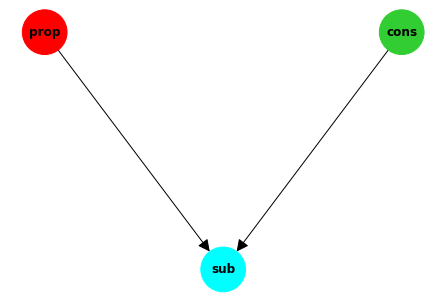

In [ ]:
#| gui
sub = Subtract(links=[Constant(1, name='cons'), Proportional(10, name='prop')], name='sub')
g = sub.graph()
print(g)
sub.draw(node_size=2000)

## Running a Function

A function can be run simply by calling the variable.

In [ ]:
#| gui
out = sub()
print(out)

1


A function can be also run in a loop with the run() method and provided the loop count.

In [ ]:
#| gui
integrator = Integration(gain=9, slow=10)
integrator.add_link(sub)
o = integrator.run(steps=10, verbose=True)

0.900 1.710 2.439 3.095 3.686 4.217 4.695 5.126 5.513 5.862 

In [ ]:
#| gui
integrator(verbose=True)

6.176 

6.17570463519

## Save and Load

Save a function to file.

In [ ]:
#| include:false

In [ ]:
import json

In [ ]:
print(ws.get_config())
ws.save("ws.json")

{'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 35, 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'}, 'weights': [1, 1, 1]}


Create a function from file.

In [ ]:
wss = WeightedSum.load("ws.json", namespace=ns)
assert ws.get_config() == wss.get_config() 
print(wss.get_config())

{'type': 'WeightedSum', 'name': 'weighted_sum', 'value': 35, 'links': {0: 'constant', 1: 'constant1', 2: 'constant2'}, 'weights': [1, 1, 1]}


# Setting Links
The next cell shows how a link is added to one function from another. In this case from an Integration function to a Constant function. So, whenever "integrator" runs it will get its input from "cons". 

In [ ]:
integrator = Integration(3, 10)
cons = Constant(5)
integrator.add_link(cons)
integrator.summary()

integration Integration | gain 3 slow 10  | 0 | links  constant 


In [ ]:
UniqueNamer.getInstance().clear() # initialises the list of function names
integ = Integration(**{'name': 'myinteg', 'value': 1, 'gain': 20, 'slow': 100})
prop = Proportional(5, name="myprop")
integ.add_link(prop)
print(integ.get_config())
assert integ.get_config() == {'type': 'Integration', 'name': 'myinteg', 'value': 1, 'links': {0: 'myprop'}, 'gain': 20, 'slow': 100}

{'type': 'Integration', 'name': 'myinteg', 'value': 1, 'links': {0: 'myprop'}, 'gain': 20, 'slow': 100}


You can also define the link when you create the function, as in this example with "Proportional".

In [ ]:
const = Constant(1, name='const')
ns = const.namespace
pr = Proportional(name='pr', links=const, namespace=ns)
pr.summary()
assert pr() == 1

pr Proportional | gain 1 | 0 | links  const 


It can be the name of the linked function.

In [ ]:
pr = Proportional(gain=10, name='pr', links='const', namespace=ns)
pr.summary()
assert pr() == 10

pr1 Proportional | gain 10 | 0 | links  const 


Or it can be a list of names.

In [ ]:
sub = Subtract(links=['const', 'pr'], namespace=ns)
sub.summary()
assert sub()==0

subtract Subtract | 0 | links  const pr 


## Running a Fucntion
A function can simply be run by calling it, without any parameters. It will use whatever input was set by the links. It returns the result of the function. In this example it will be 5 \* 3 / 10, that is, input \* gain / slow.

In [ ]:
output = integrator()
print(output)
assert output == 1.5

1.5


In [ ]:
print(integrator.get_config())

{'type': 'Integration', 'name': 'integration', 'value': 1.5, 'links': {0: 'constant'}, 'gain': 3, 'slow': 10}


## Examples

### Configuration
Create a function from the configuration of another.

In [ ]:

integrator = Integration(3, 10)
ns=integrator.namespace
cons = Constant(5, namespace=ns)
integrator.add_link(cons)
config = integrator.get_config()
inte = Integration.from_config(config, namespace=ns)
print(inte())
target = {'type': 'Integration', 'name': 'integration', 'value': 1.5, 'links': {0: 'constant'}, 'gain': 3, 'slow': 10}
#print(target)
assert inte.get_config() == target

1.5


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()